<a href="https://colab.research.google.com/github/lazybear-0425/EWC_Observation/blob/main/2025-03-25_08_11_39.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 - Life Lone Learning
 - Elastic Weight Consolidation (EWC)
    - [教學](https://www.kaggle.com/code/hughiephan/elastic-weight-consolidation-on-minst)
    - [Paper](https://arxiv.org/pdf/1612.00796)
    - 公式 $\mathcal{L}(\theta) = \mathcal{L}_B(\theta) + \frac\lambda2\sum^n_{i=1}F_i(\theta_i - \theta^*_{A,i})^2$
        - B是指目前任務，A是指前一個任務
 - [教學2](https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb)

In [1]:
import torch
from torch import nn
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, Lambda
import numpy as np
from torchvision.datasets import CIFAR10 as FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.nn.functional import cross_entropy

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import random

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True  # 確保 CuDNN 使用確定性算法
torch.backends.cudnn.benchmark = False  # 禁止自適應選擇最佳內核，確保結果可重現

In [4]:
batch_size = 256
epochs = 10
task = 2

 - [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)

In [5]:
def trans_compose(i=0):
    return Compose([
        # lambda x : np.rot90(x, i, axes=[0, 1]).copy(), # 使連續
        # lambda x: np.expand_dims(x, axis=-1),  # 因為ToTensor要PIL or ndarray(H x W x C)，之後轉成Tensor(C x H x W)
        ToTensor(),
        # Lambda(lambda x : x / 255.),
        RandomRotation((90 * i, 90 * i)),
        Normalize(mean=[0.0], std=[1])
    ])

In [6]:
# preprocessing
# train_task_1 = FashionMNIST('data', train=True, transform=trans_compose(0), download=True)
# train_task_2 = FashionMNIST('data', train=True, transform=trans_compose(1), download=True)

test_task_1 = FashionMNIST('data', train=False, transform=trans_compose(0), download=True)
test_task_2 = FashionMNIST('data', train=False, transform=trans_compose(1), download=True)

task_1_loader = DataLoader(test_task_1, batch_size=batch_size)
task_2_loader = DataLoader(test_task_2, batch_size=batch_size)

100%|██████████| 170M/170M [00:03<00:00, 43.5MB/s]


In [7]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        # self.classifier = nn.Sequential(
        #     nn.Conv2d(1, 10, kernel_size=5),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        #     nn.Conv2d(10, 20, kernel_size=5),
        #     nn.Dropout2d(),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        # )
        # self.dense = nn.Sequential(
        #     nn.Linear(320, 50),
        #     nn.ReLU(),
        #     nn.Dropout(),
        #     nn.Linear(50, 10)
        # )
        self.net = nn.Sequential(
            nn.Flatten(),
            # nn.LazyLinear(100),
            # nn.ReLU(),
            nn.LazyLinear(10)
        )
    def forward(self, X):
        # return self.dense(self.classifier(X).view(-1, 320))
        return self.net(X)

In [8]:
def evaluate(model, dataloader, num_data, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")

    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            test_loss += cross_entropy(output, label)
            test_acc += (output.argmax(1) == label).sum()
    print('\033[33m' +
          f'Task {num_task} Acc: {test_acc / num_data: .4f}, Loss: {test_loss / num_data: .4f}' +
          '\033[0m')

In [9]:
def training_Setting(model):
    optimizer = Adam(model.parameters())
    loss = CrossEntropyLoss()
    return optimizer, loss

 - Fisher Matrix
     - 儲存權重對模型重要性
     - 計算方法
         - [LINK](https://github.com/db434/EWC)
             - 這個版本是**取樣** $\rightarrow$ 計算梯度
         - 這邊的範例程式碼是直接**整個資料**來計算梯度
         - 公式
             - $F_j = \frac1m \sum^m_{i=1}(\frac{\partial \log (P(x_i|\theta_j))}{\partial \theta_j})^2$

In [10]:
# EWC
optim_para = {}
fisher_matrix = {}
ewc_lambda = 10

def record_parameter(model, train_data, optimizer, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model.train()
    optimizer.zero_grad()

    fisher_matrix[num_task] = {}
    optim_para[num_task] = {}

    # Initialize Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] = torch.zeros_like(param.data)

    # Calculate Fisher Matrix
    for data in train_loader:
        img, label = data
        img, label = img.to(device), label.to(device).long()
        output = model(img)
        output_loss = cross_entropy(output, label)
        output_loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_matrix[num_task][name] += param.grad.data.clone().pow(2)

    # Average Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] /= len(train_loader)

    # Save optimal parameters
    for name, param in model.named_parameters():
        optim_para[num_task][name] = param.data.clone()

In [11]:
def training(model, test_loader : list, test_num : list, epochs = 10,  num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    print(f'Task {num_task} Start!')

    train_data = FashionMNIST('data', train=True, transform=trans_compose(num_task), download=True)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # plt.imshow(train_data[0][0].reshape(28, 28), cmap='gray')
    # plt.title('Task' + str(num_task))
    # plt.show()

    # optimizer, loss = training_Setting(model)
    optimizer = Adam(model.parameters()) #SGD(model.parameters(), lr=0.01, momentum=0.9)

    for i in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0
        for data in train_loader:
            optimizer.zero_grad()

            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            output_loss = cross_entropy(output, label)
            # Record
            train_acc += (output.argmax(1) == label).sum()
            # BP
            ewc_loss = 0
            for t in range(num_task):
                for name, param in model.named_parameters():
                    if t in optim_para:
                        fisher = fisher_matrix[t][name]
                        optim = optim_para[t][name]
                        if fisher.requires_grad == True or optim.requires_grad == True:
                            raise NotImplementedError('Frozen it!')
                        # output_loss += ewc_lambda * (fisher * (optim - param).pow(2)).sum() # .detach()
                        ewc_loss += (fisher * (optim - param).pow(2)).sum() * ewc_lambda
            # if tmp != 0: print(tmp)
            output_loss += ewc_loss
            train_loss += output_loss.detach()
            output_loss.backward()
            optimizer.step()
        print(f'Epoch\t{i + 1}\tAcc: {train_acc / len(train_data): .4f}, Loss: {train_loss / len(train_data): .4f}')
    record_parameter(model, train_data, optimizer, num_task=num_task)
    # Evaluate Task 0 & 1
    task_id = 0
    for num_data, loader in zip(test_num, test_loader):
        evaluate(model, loader, num_data, task_id)
        task_id = task_id + 1
    print() # End of Training

 - nn.Module
    - named_pa​​rameters()
         - 給出網絡層的名字和參數的迭代器
    - parameters()
         - 參數的迭代器
    - [Reference](https://blog.csdn.net/qq_36530992/article/details/102729585)

In [12]:
model = Module().to(device)

for i in range(task):
    training(model, [task_1_loader, task_2_loader], [len(test_task_1), len(test_task_2)], num_task=i, epochs=epochs)

Task 0 Start!
Epoch	1	Acc:  0.3112, Loss:  0.0076
Epoch	2	Acc:  0.3615, Loss:  0.0072
Epoch	3	Acc:  0.3768, Loss:  0.0070
Epoch	4	Acc:  0.3795, Loss:  0.0070
Epoch	5	Acc:  0.3885, Loss:  0.0069
Epoch	6	Acc:  0.3922, Loss:  0.0069
Epoch	7	Acc:  0.3981, Loss:  0.0068
Epoch	8	Acc:  0.3972, Loss:  0.0068
Epoch	9	Acc:  0.3976, Loss:  0.0068
Epoch	10	Acc:  0.4005, Loss:  0.0068
Task 0 Acc:  0.3936, Loss:  0.0070
Task 1 Acc:  0.2274, Loss:  0.0090

Task 1 Start!
Epoch	1	Acc:  0.2414, Loss:  0.0087
Epoch	2	Acc:  0.2444, Loss:  0.0086
Epoch	3	Acc:  0.2432, Loss:  0.0087
Epoch	4	Acc:  0.2420, Loss:  0.0087
Epoch	5	Acc:  0.2424, Loss:  0.0087
Epoch	6	Acc:  0.2449, Loss:  0.0087
Epoch	7	Acc:  0.2454, Loss:  0.0087
Epoch	8	Acc:  0.2437, Loss:  0.0087
Epoch	9	Acc:  0.2418, Loss:  0.0087
Epoch	10	Acc:  0.2452, Loss:  0.0087
Task 0 Acc:  0.3906, Loss:  0.0071
Task 1 Acc:  0.2476, Loss:  0.0086



 - Task 0

Accuracy 0.3906
Classification Report
              precision    recall  f1-score   support

    airplane       0.32      0.66      0.43      1000
  automobile       0.44      0.47      0.45      1000
        bird       0.34      0.22      0.27      1000
         cat       0.32      0.25      0.28      1000
        deer       0.38      0.28      0.32      1000
         dog       0.47      0.14      0.22      1000
        frog       0.43      0.47      0.45      1000
       horse       0.40      0.53      0.46      1000
        ship       0.47      0.45      0.46      1000
       truck       0.43      0.46      0.44      1000

    accuracy                           0.39     10000
   macro avg       0.40      0.39      0.38     10000
weighted avg       0.40      0.39      0.38     10000



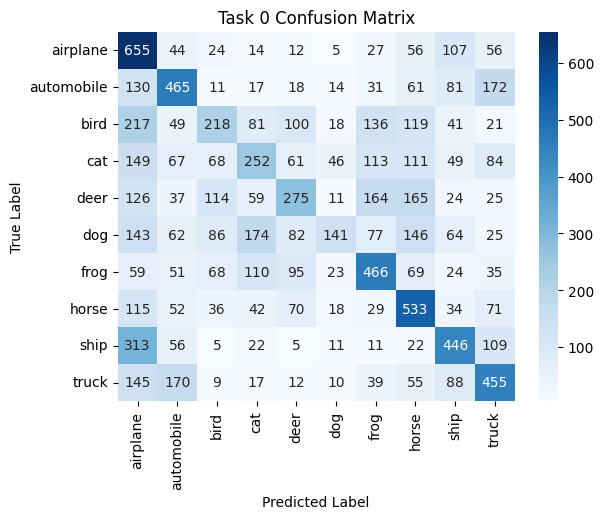

In [13]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_1_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_1.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_1.classes, yticklabels=test_task_1.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 0 Confusion Matrix")
plt.show()

 - Task 1

Accuracy 0.2476
Classification Report
              precision    recall  f1-score   support

    airplane       0.24      0.65      0.36      1000
  automobile       0.28      0.24      0.26      1000
        bird       0.15      0.13      0.14      1000
         cat       0.20      0.20      0.20      1000
        deer       0.24      0.20      0.22      1000
         dog       0.21      0.07      0.11      1000
        frog       0.37      0.47      0.41      1000
       horse       0.15      0.14      0.15      1000
        ship       0.32      0.28      0.30      1000
       truck       0.26      0.08      0.13      1000

    accuracy                           0.25     10000
   macro avg       0.24      0.25      0.23     10000
weighted avg       0.24      0.25      0.23     10000



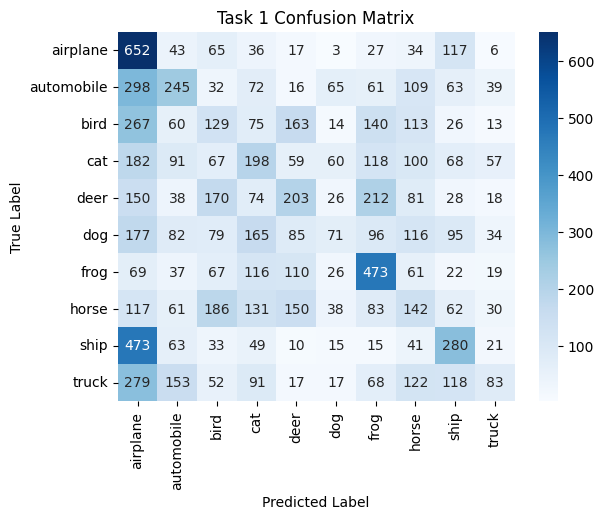

In [14]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_2_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_2.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_2.classes, yticklabels=test_task_2.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 1 Confusion Matrix")
plt.show()

net.1.weight
torch.Size([10, 3072])
Max fisher is 1.04624 and it's parameter diff is 0.00041
Min Parameter diff is 0.00161 and it's fisher is 0.10010
fisher > parameter diff: 3072
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

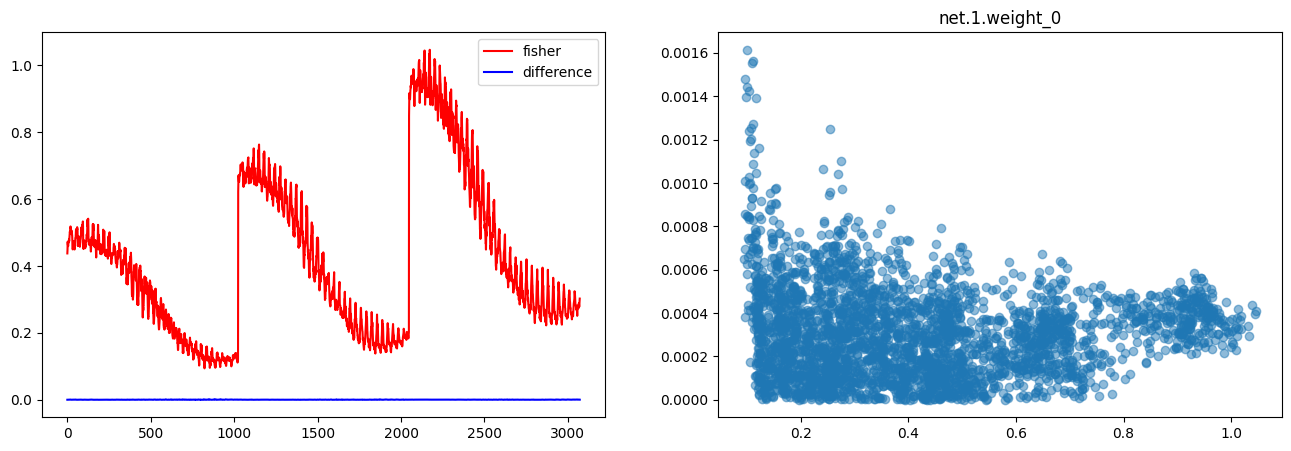

Max fisher is 0.46431 and it's parameter diff is 0.00048
Min Parameter diff is 0.00965 and it's fisher is 0.03831
fisher > parameter diff: 3072
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

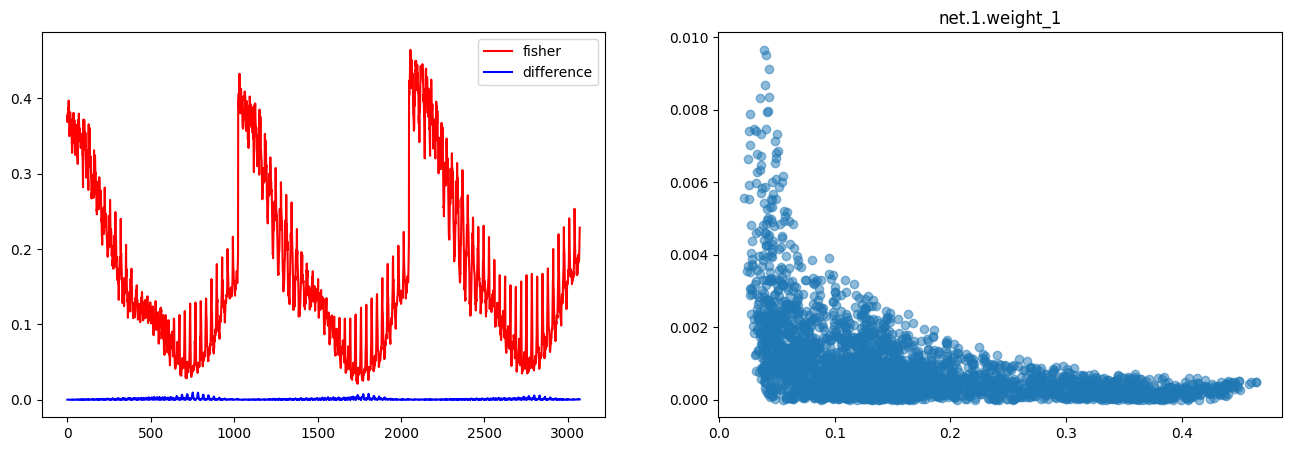

Max fisher is 2.00282 and it's parameter diff is 0.00008
Min Parameter diff is 0.00094 and it's fisher is 0.69157
fisher > parameter diff: 3072
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

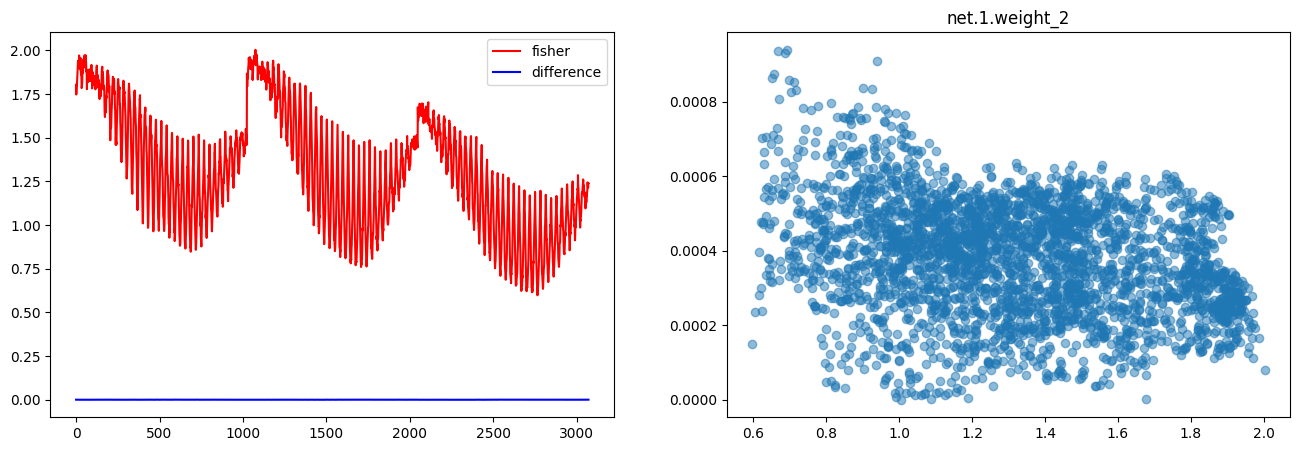

Max fisher is 4.83327 and it's parameter diff is 0.00013
Min Parameter diff is 0.00040 and it's fisher is 2.25191
fisher > parameter diff: 3072
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

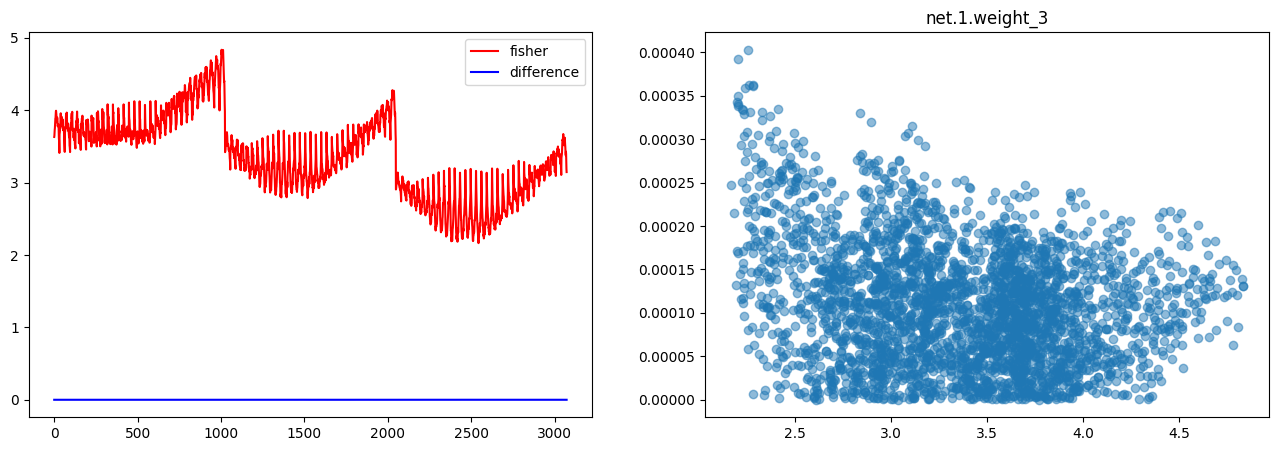

Max fisher is 0.76243 and it's parameter diff is 0.00018
Min Parameter diff is 0.00111 and it's fisher is 0.54017
fisher > parameter diff: 3072
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

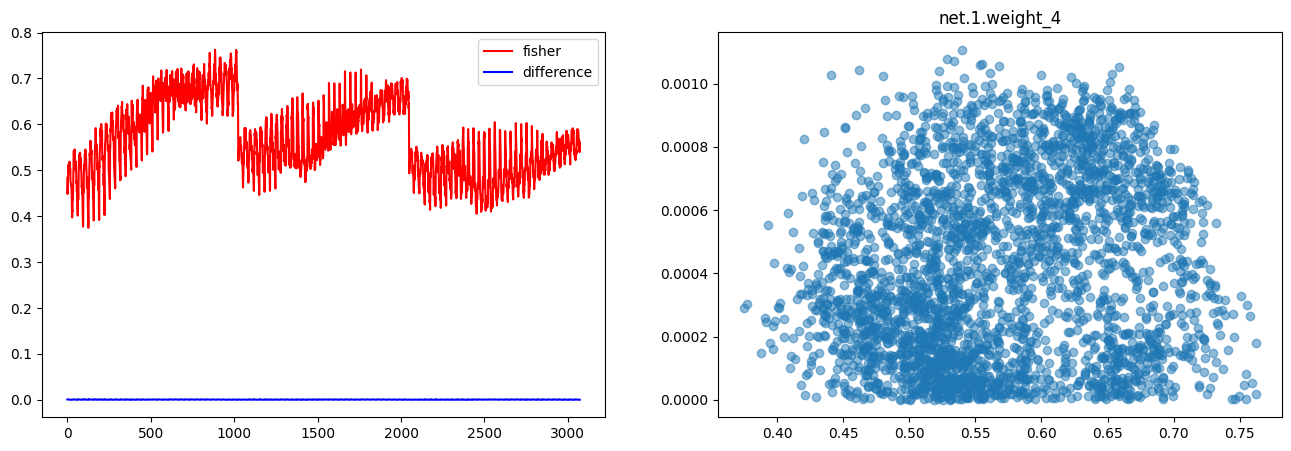

Max fisher is 0.50635 and it's parameter diff is 0.00035
Min Parameter diff is 0.00226 and it's fisher is 0.19423
fisher > parameter diff: 3072
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

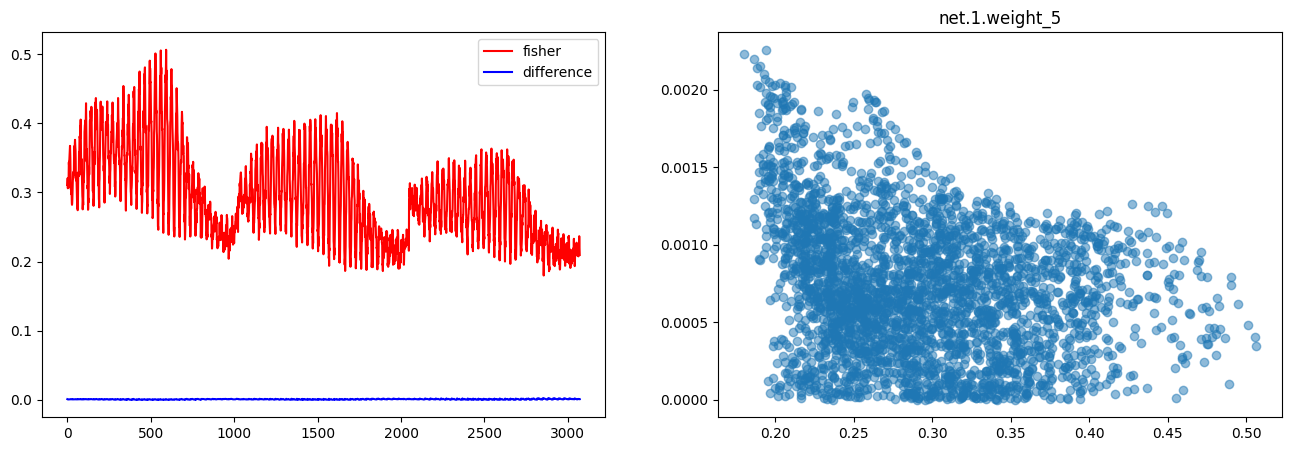

Max fisher is 0.03891 and it's parameter diff is 0.00064
Min Parameter diff is 0.05258 and it's fisher is 0.00070
fisher > parameter diff: 2118
fisher <= parameter diff: 954


<Figure size 640x480 with 0 Axes>

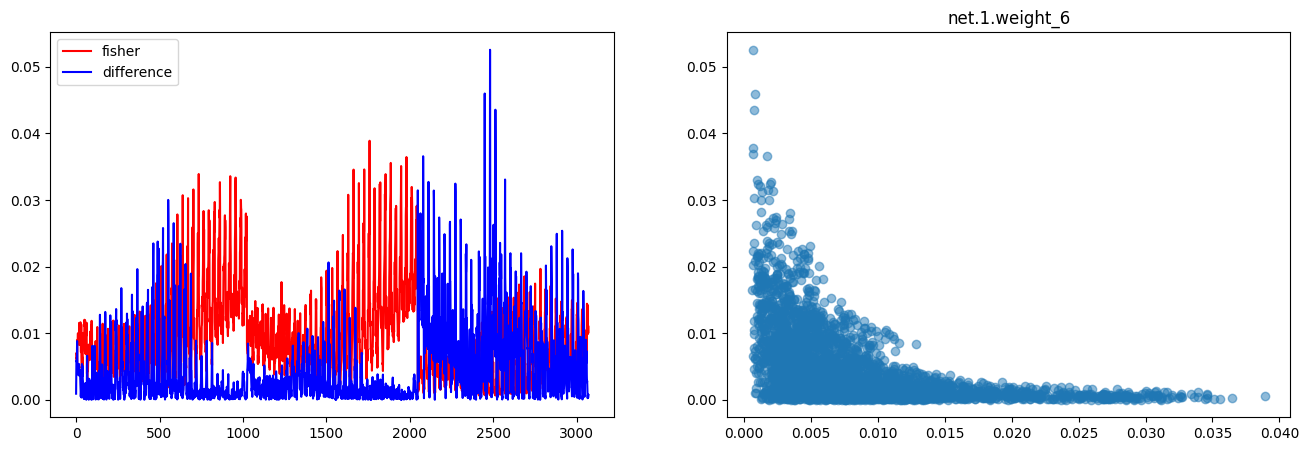

Max fisher is 4.78318 and it's parameter diff is 0.00012
Min Parameter diff is 0.00059 and it's fisher is 2.45129
fisher > parameter diff: 3072
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

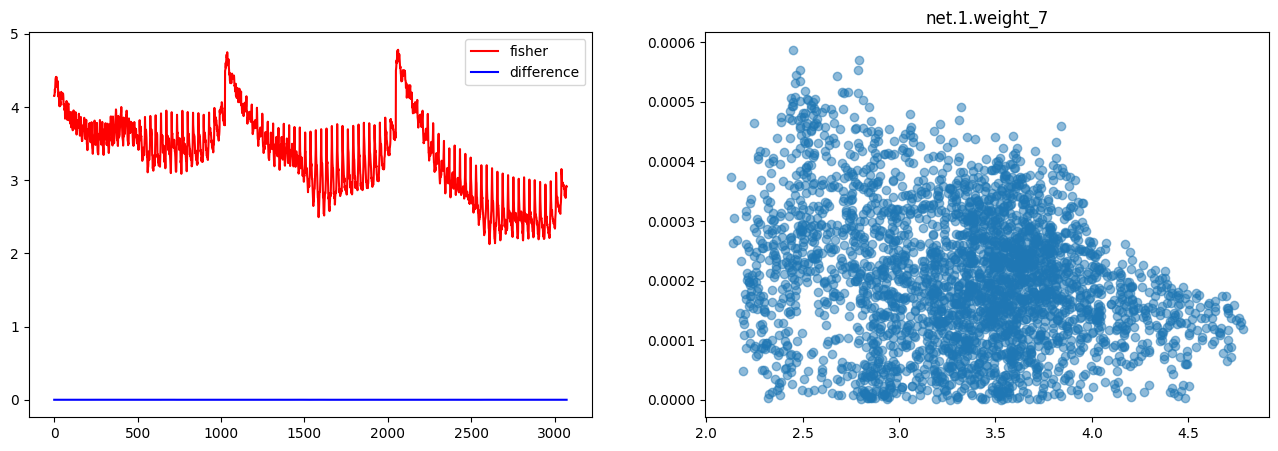

Max fisher is 6.52115 and it's parameter diff is 0.00035
Min Parameter diff is 0.00063 and it's fisher is 2.15133
fisher > parameter diff: 3072
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

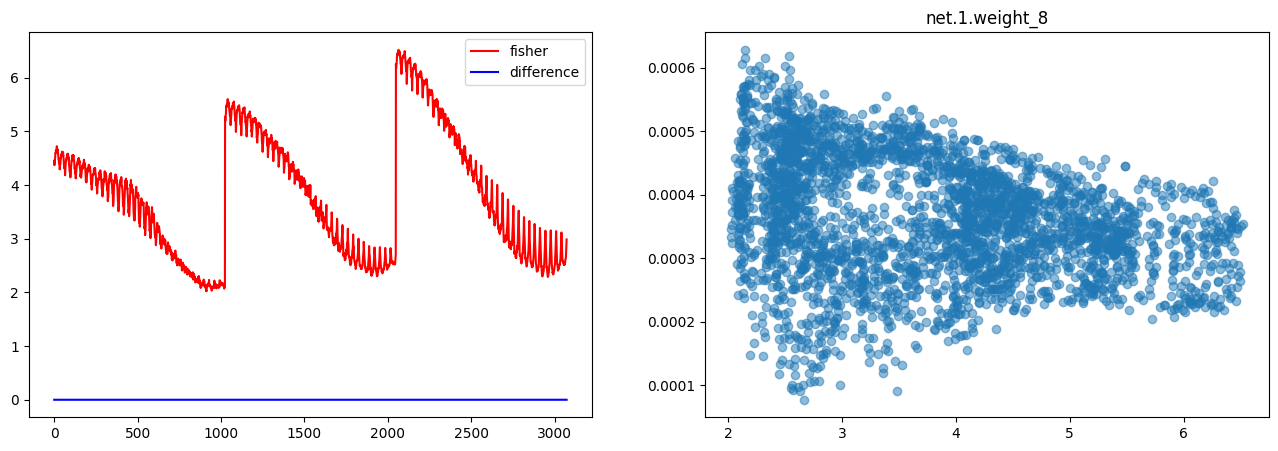

Max fisher is 4.19488 and it's parameter diff is 0.00000
Min Parameter diff is 0.00133 and it's fisher is 1.05412
fisher > parameter diff: 3072
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

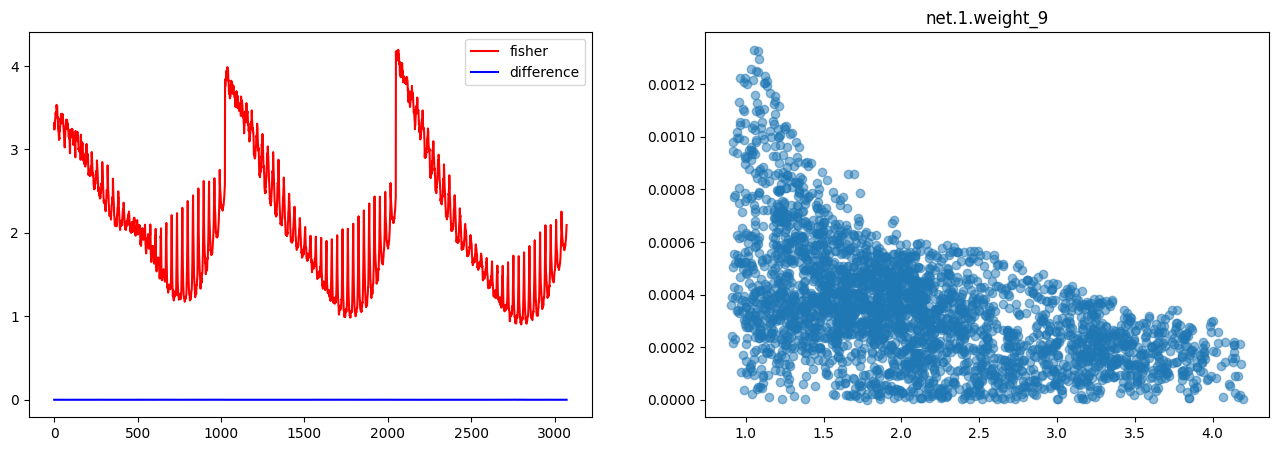


net.1.bias
torch.Size([10])
Max fisher is 15.24730 and it's parameter diff is 0.00011
Min Parameter diff is 0.00052 and it's fisher is 0.24107
fisher > parameter diff: 10
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

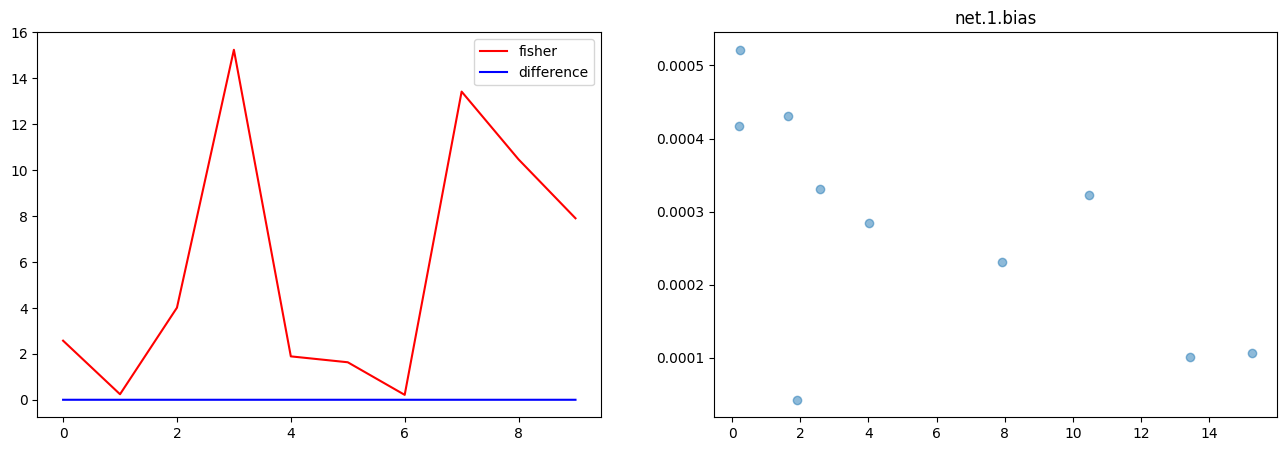

In [15]:
def plot(fisher_matrix, optim_para, param, name):
  plt.cla(); plt.clf()
  #print(fisher_matrix.shape, optim_para.shape, param.shape)
  fisher = fisher_matrix.cpu().detach()
  optim = optim_para.cpu().detach()
  param = param.cpu().detach()

  fisher_max = np.argmax(fisher)
  param_diff_max = np.argmax((optim - param).abs())
  print(f'Max fisher is {fisher[fisher_max]:.5f} and it\'s parameter diff is {(optim - param).abs()[fisher_max]:.5f}')
  print(f'Min Parameter diff is {(optim - param).abs()[param_diff_max]:.5f} and it\'s fisher is {fisher[param_diff_max]:.5f}')
  # compare
  print('fisher > parameter diff: {}'.format((fisher > (optim - param).abs()).sum()))
  print('fisher <= parameter diff: {}'.format((fisher <= (optim - param).abs()).sum()))

  # plot
  fig, ax = plt.subplots(1, 2, figsize=(16, 5)) # row, col
  ax[0].plot(fisher.reshape(-1), 'r', label='fisher')
  ax[0].plot((optim - param).abs().reshape(-1), 'b', label='difference')
  ax[0].legend()

  ax[1].scatter(fisher, (optim - param).abs().reshape(-1), alpha=0.5)
  plt.title(name)
  plt.show()

# test
idx = 0
for name, param in model.named_parameters():

  # Name
  print(name)
  print(param.detach().shape)

  if len(param.detach().shape) != 1:
    for i in range(param.detach().shape[0]):
      plot(fisher_matrix[0][name][i], optim_para[0][name][i], param[i], f'{name}_{i}')
  else:
    plot(fisher_matrix[0][name], optim_para[0][name], param, name)
  # END
  idx += 1
  print()

In [16]:
import datetime
import pytz

now = datetime.datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d_%H_%M_%S")
print(now)

2025-03-30_12_13_11
